In [19]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity

In [20]:
data = {}
with open("rl-run-dqn-2-data.json", "r") as f:
    data = json.load(f)

In [21]:
max_epsilon = 0
min_epsilon = np.inf
map_name = list(data.keys())[0]
for i in range(len(data[map_name])):
        epsilon = data[map_name][i]["info"]["epsilon"]
        max_epsilon = max(max_epsilon, epsilon)
        min_epsilon = min(min_epsilon, epsilon)

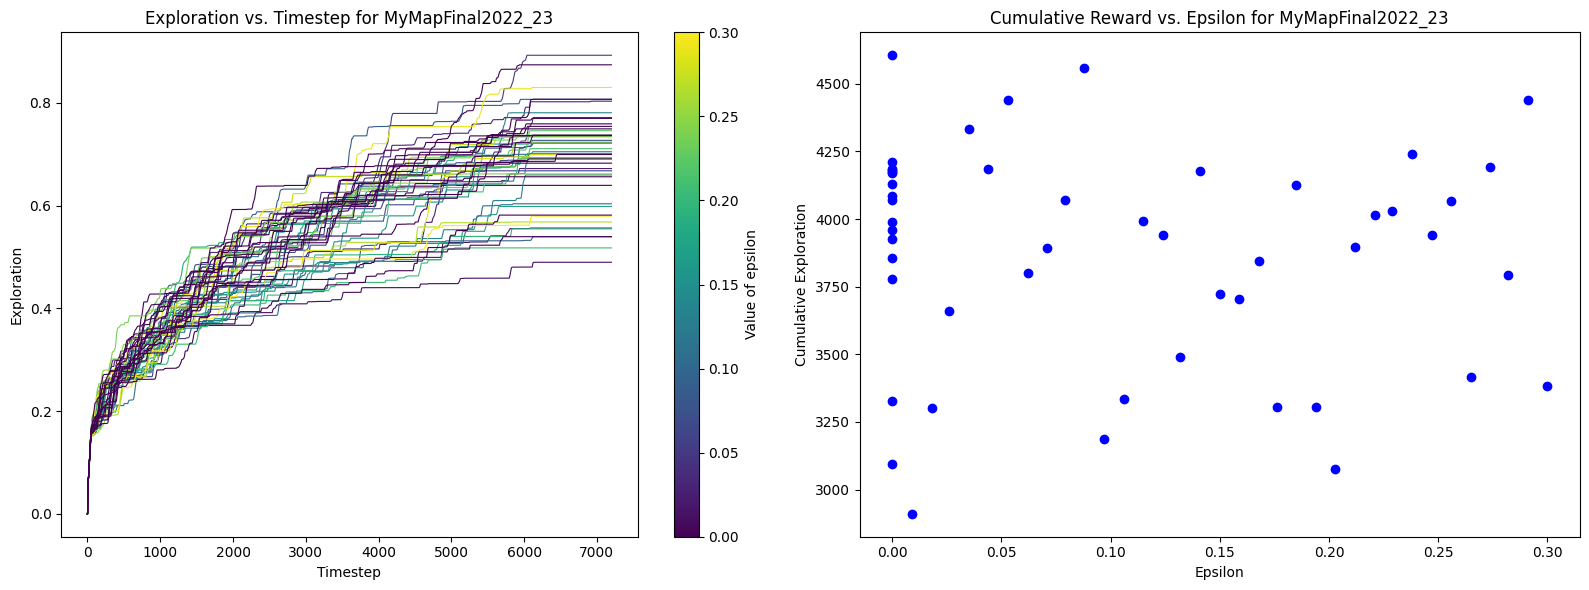

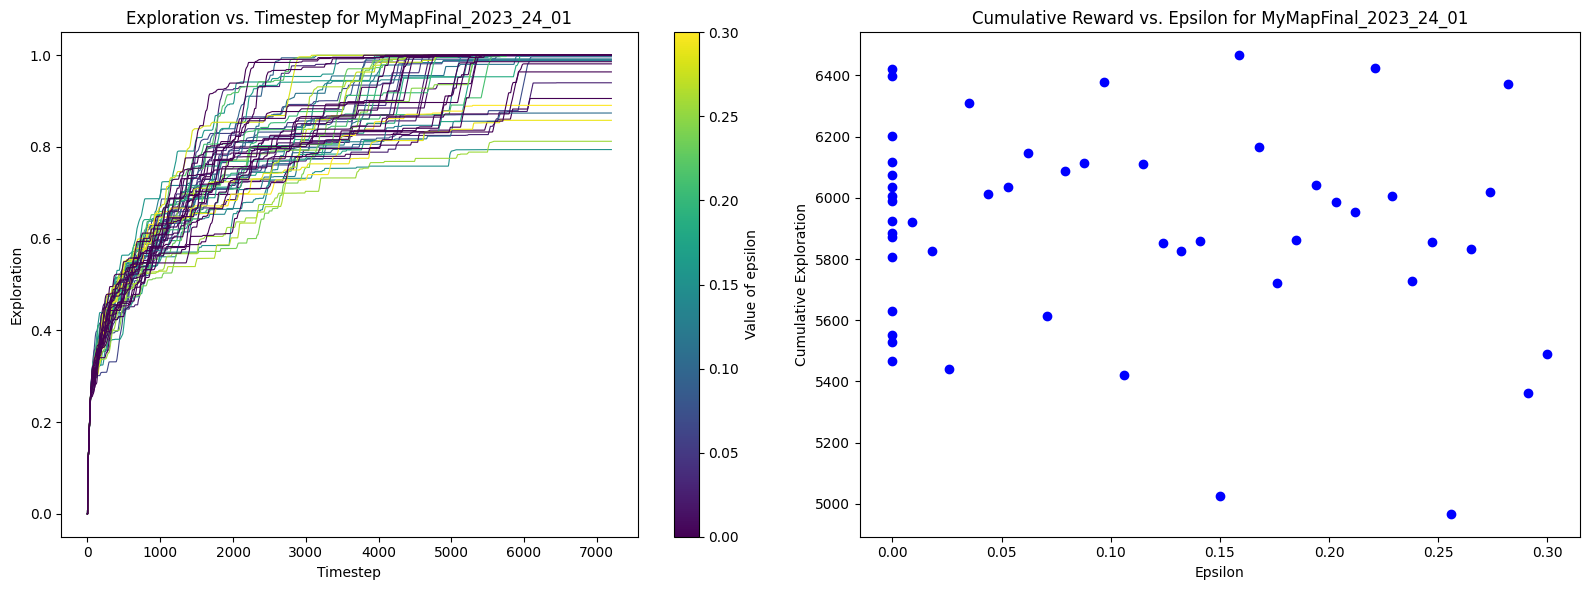

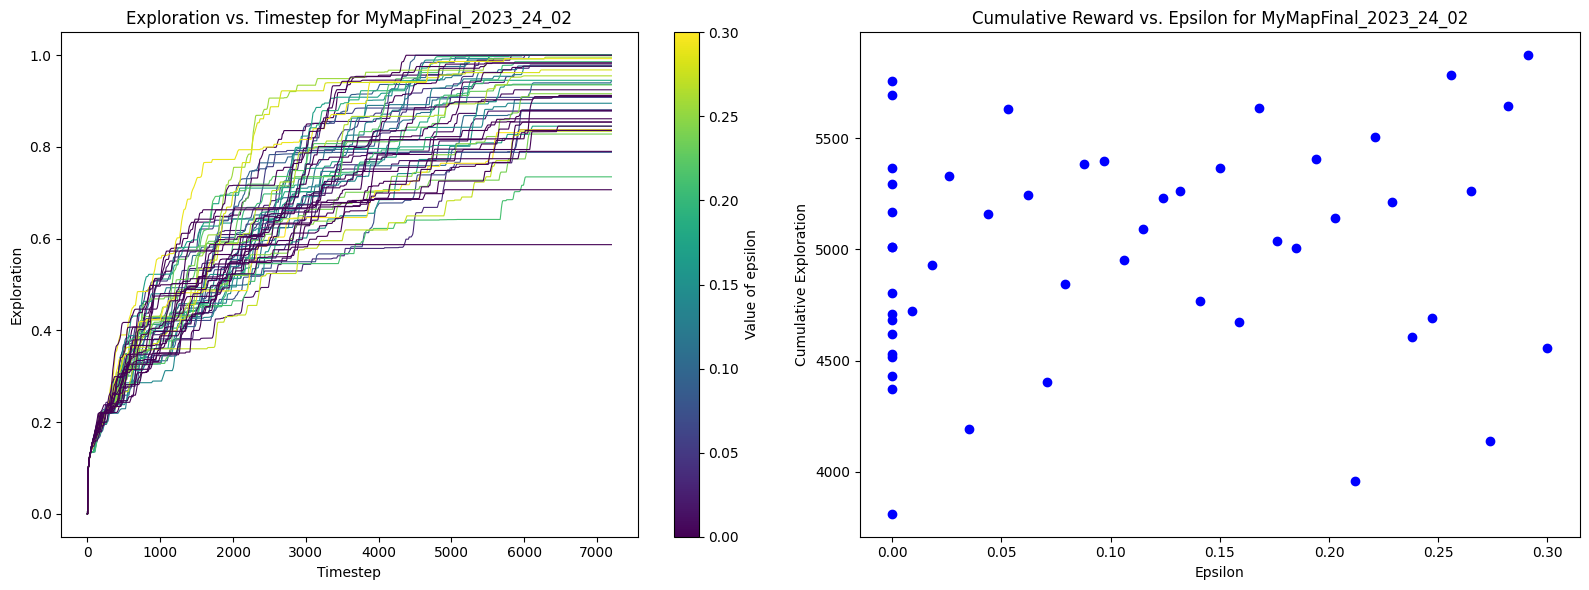

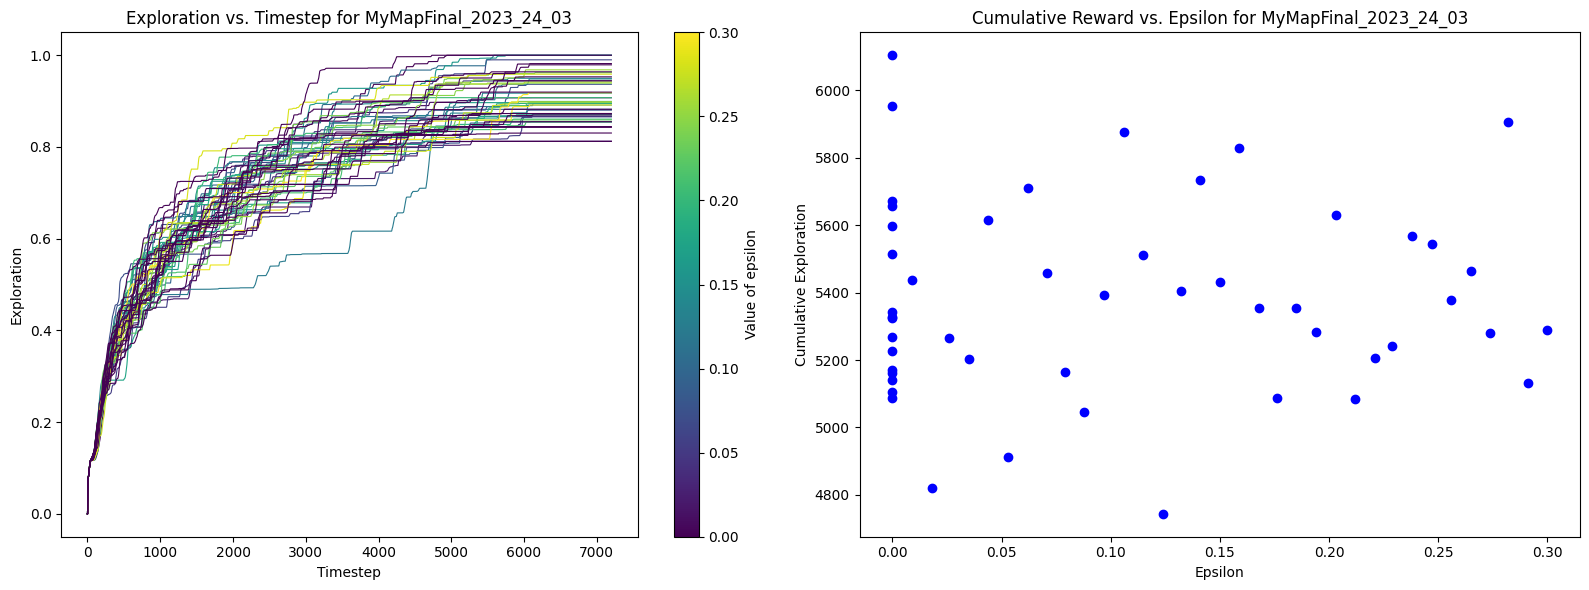

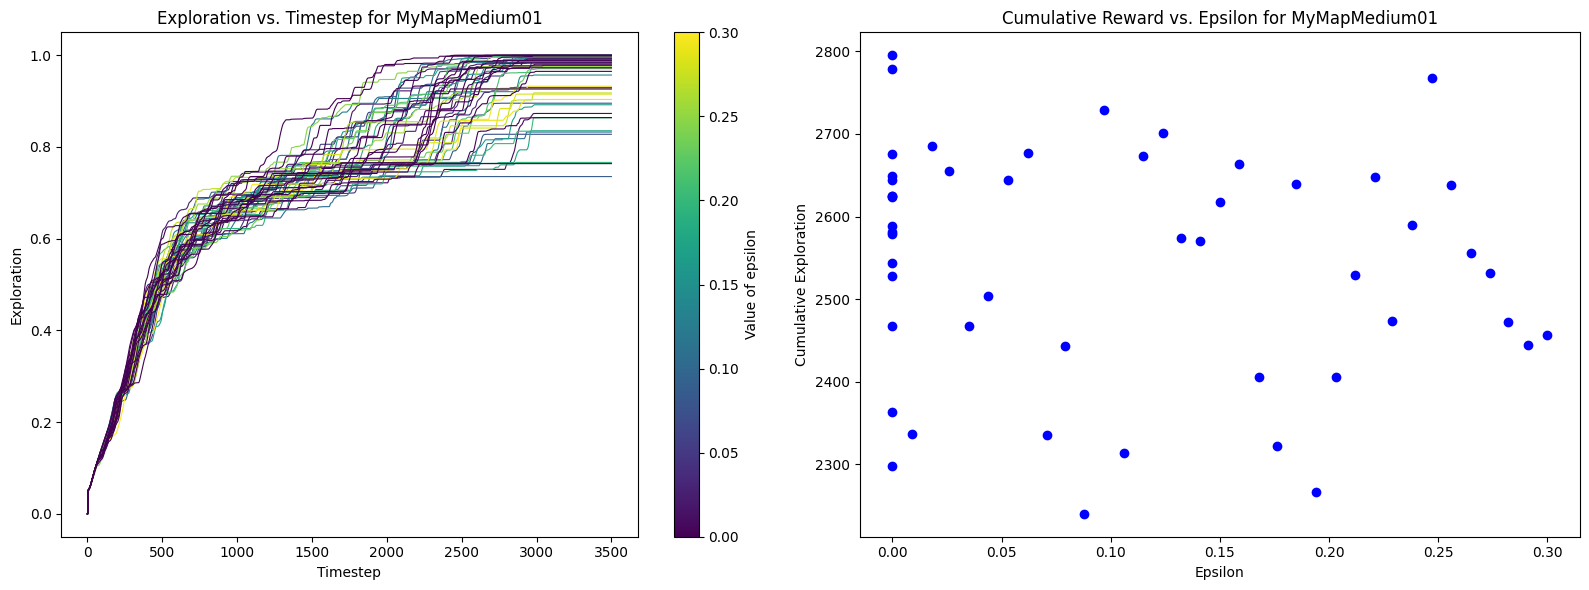

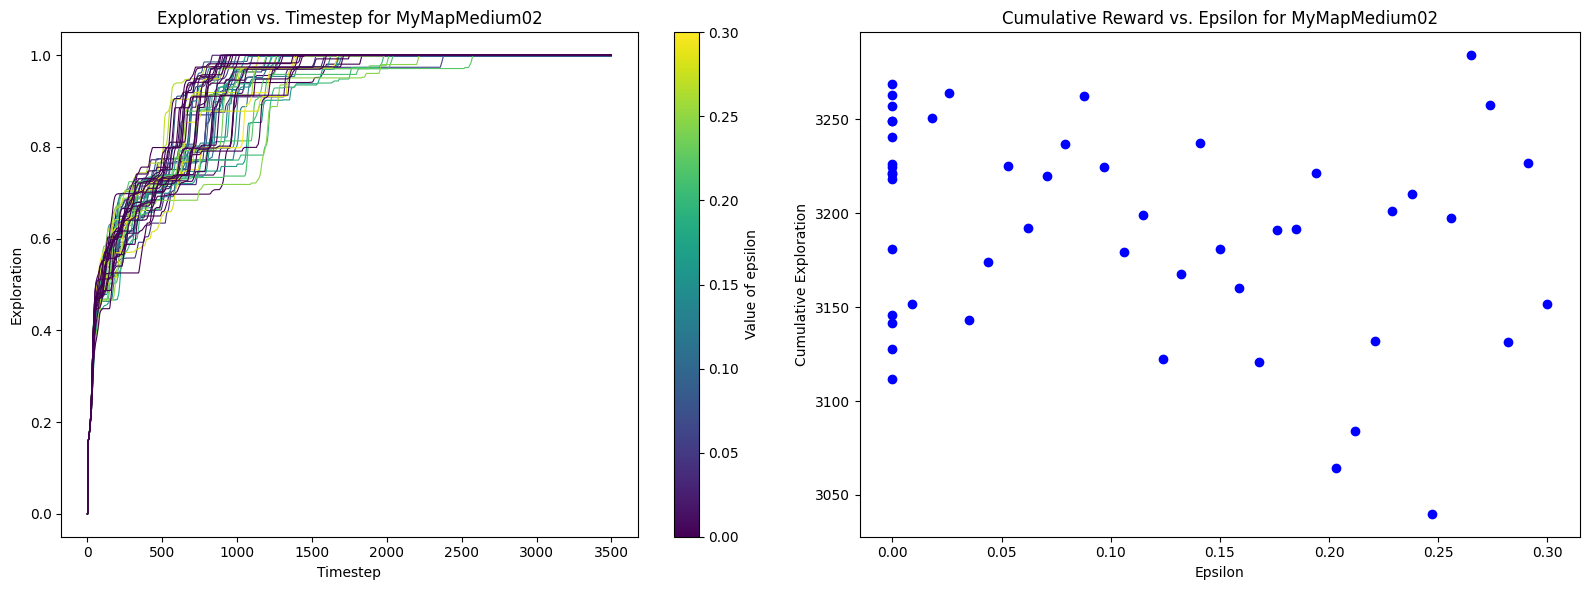

In [22]:
norm = plt.Normalize(min_epsilon, max_epsilon)
cm = plt.cm.viridis

for map_name in data:
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot the exploration in respect to timestep (Left plot)
    ax1.set_title(f"Exploration vs. Timestep for {map_name}")
    for i in range(len(data[map_name])):
        ax1.plot(
            data[map_name][i]["score"], 
            color=cm(norm(data[map_name][i]["info"]["epsilon"])), 
            linewidth=0.8
        )
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])  # Required for ScalarMappable
    fig.colorbar(sm, label="Value of epsilon", ax=ax1)
    ax1.set_xlabel("Timestep")
    ax1.set_ylabel("Exploration")
    
    # Plot the cumulative reward as a function of epsilon (Right plot)
    ax2.set_title(f"Cumulative Reward vs. Epsilon for {map_name}")
    cumulative_rewards = [sum(data[map_name][i]["score"]) for i in range(len(data[map_name]))]
    epsilons = [data[map_name][i]["info"]["epsilon"] for i in range(len(data[map_name]))]
    ax2.plot(epsilons, cumulative_rewards, marker="o", linestyle="None", color="blue", linewidth=1.5)
    ax2.set_xlabel("Epsilon")
    ax2.set_ylabel("Cumulative Exploration")
    
    # Adjust layout and show
    plt.tight_layout()
    plt.show()

In [23]:
data_last = {}
with open("rl-run-data.json", "r") as f:
    data_last = json.load(f)

In [24]:
def get_transitions(data):
    transitions = []
    for map_name in data:
        for i in range(len(data[map_name])):
            map_data = data[map_name][i]
            for transition in map_data["run"]["obs"]:
                transitions.append(transition)
    return np.array(transitions)

In [25]:
transitions_dqn = get_transitions(data)
transitions_det = get_transitions(data_last)

In [26]:
def multivariate_kl_divergence(data_p, data_q, bandwidth=0.1, n_samples=10000):
    """
    Compute the multivariate KL divergence between two datasets using KDE.
    
    Args:
        data_p (ndarray): Samples from distribution P (N x D).
        data_q (ndarray): Samples from distribution Q (N x D).
        bandwidth (float): Bandwidth for KDE.
        n_samples (int): Number of samples for numerical integration.
        
    Returns:
        float: Estimated KL divergence.
    """
    # Fit KDEs for P and Q
    kde_p = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data_p)
    kde_q = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(data_q)

    # Draw samples from P
    sample_points = data_p[np.random.choice(data_p.shape[0], n_samples, replace=True)]

    # Estimate log densities for P and Q at sample points
    log_density_p = kde_p.score_samples(sample_points)
    log_density_q = kde_q.score_samples(sample_points)

    # Calculate KL divergence
    kl_div = np.mean(log_density_p - log_density_q)
    return kl_div,log_density_p,log_density_q,kde_p,kde_q

In [27]:
def get_rewards(data):
    rewards = []
    local_reward = []
    for map_name in data:
        for i in range(len(data[map_name])):
            map_data = data[map_name][i]
            for j in range(len(map_data["run"]["reward"])):
                if map_data["run"]["reward"][j][0] < 0.995:
                    rewards.append(map_data["run"]["reward"][j][0])
                    local_reward.append(map_data["run"]["obs"][j][38]*map_data["run"]["obs"][j][37]+map_data["run"]["obs"][j][38]*map_data["run"]["obs"][j][37])
    return np.array(rewards),np.array(local_reward)

rewards_q,local_reward_q = get_rewards(data)
rewards_det,local_reward_det = get_rewards(data_last)

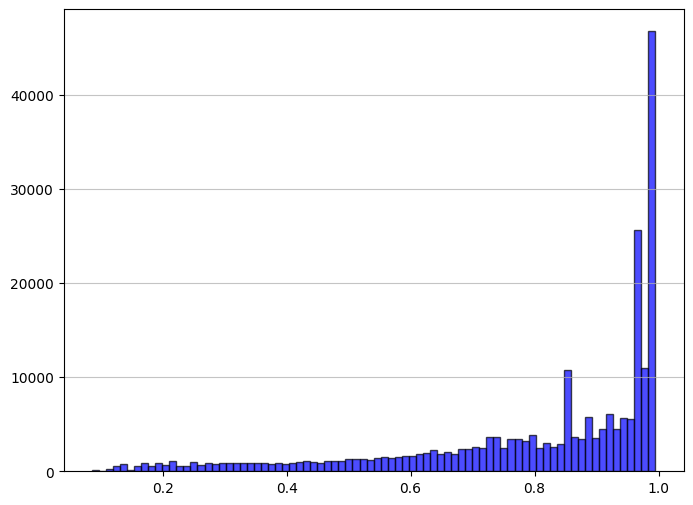

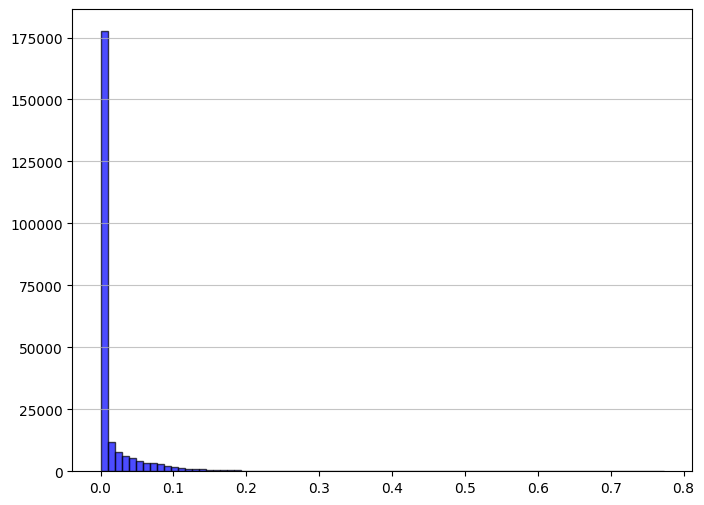

In [32]:
plt.figure(figsize=(8, 6))
plt.hist(rewards_det, bins=80, color='blue', edgecolor='black', alpha=0.7)
plt.grid(axis='y', alpha=0.75)

plt.figure(figsize=(8, 6))
plt.hist(local_reward_det, bins=80, color='blue', edgecolor='black', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [29]:
def get_actions(data):
    transitions = []
    for map_name in data:
        for i in range(len(data[map_name])):
            map_data = data[map_name][i]
            for i in range(len(map_data["run"]["action"])):
                if map_data["run"]["reward"][i][0]>0.995:
                    continue
                transitions.append(np.argmax(map_data["run"]["action"][i]))
    return np.array(transitions)

In [30]:
actions_q = get_actions(data)
actions_det = get_actions(data_last)
total_actions = np.concatenate((actions_q, actions_det))

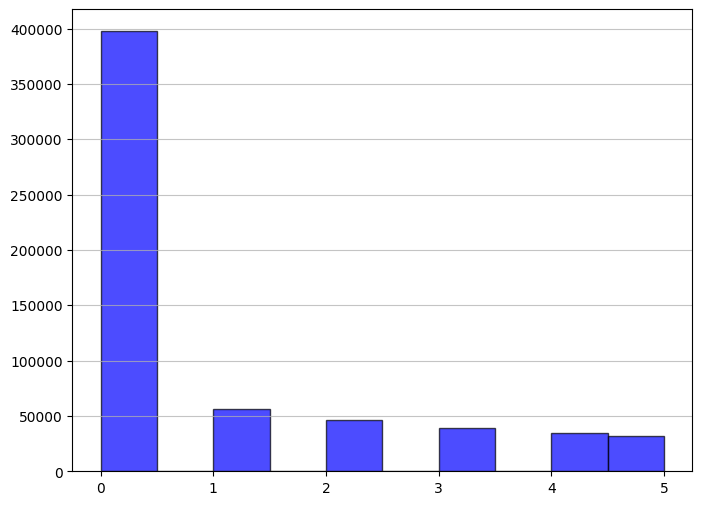

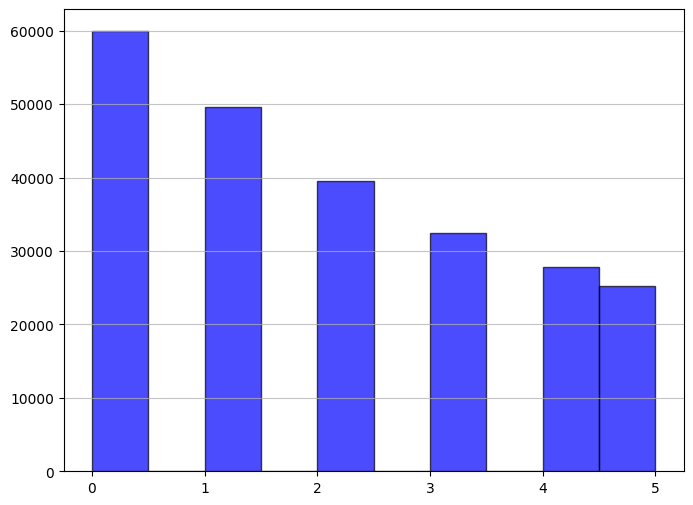

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(total_actions, color='blue', edgecolor='black', alpha=0.7)
plt.grid(axis='y', alpha=0.75)

plt.figure(figsize=(8, 6))
plt.hist(actions_det, color='blue', edgecolor='black', alpha=0.7)
plt.grid(axis='y', alpha=0.75)
plt.show()